In [1]:
!pip install kerassurgeon
!pip install tensorflow-gpu==1.14.0
!pip install -U git+https://github.com/qubvel/efficientnet

     |████████████████████████████████| 377.0MB 42kB/s 
     |████████████████████████████████| 3.2MB 55.6MB/s 
     |████████████████████████████████| 491kB 38.7MB/s 
ERROR: tensorflow 1.15.0 has requirement tensorboard<1.16.0,>=1.15.0, but you'll have tensorboard 1.14.0 which is incompatible.
ERROR: tensorflow 1.15.0 has requirement tensorflow-estimator==1.15.1, but you'll have tensorflow-estimator 1.14.0 which is incompatible.
  Found existing installation: tensorboard 1.15.0
    Uninstalling tensorboard-1.15.0:
      Successfully uninstalled tensorboard-1.15.0
  Found existing installation: tensorflow-estimator 1.15.1
    Uninstalling tensorflow-estimator-1.15.1:
      Successfully uninstalled tensorflow-estimator-1.15.1
  Cloning https://github.com/qubvel/efficientnet to /tmp/pip-req-build-kjiukcm7
  Running command git clone -q https://github.com/qubvel/efficientnet /tmp/pip-req-build-kjiukcm7
  Created wheel for efficientnet: filename=efficientnet-1.0.0-cp36-none-any.whl size=17

In [2]:
!wget https://www.dropbox.com/s/ooyb72fftf4gy81/train_DETg9GD.zip
!wget https://www.dropbox.com/s/zzzabhbmr5mi0bo/test_Bh8pGW3.zip

--2020-01-21 07:10:49--  https://www.dropbox.com/s/ooyb72fftf4gy81/train_DETg9GD.zip
Resolving www.dropbox.com (www.dropbox.com)... 162.125.8.1, 2620:100:601b:1::a27d:801
Connecting to www.dropbox.com (www.dropbox.com)|162.125.8.1|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: /s/raw/ooyb72fftf4gy81/train_DETg9GD.zip [following]
--2020-01-21 07:10:50--  https://www.dropbox.com/s/raw/ooyb72fftf4gy81/train_DETg9GD.zip
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://uc533fd0c53adbe2c4a18e954204.dl.dropboxusercontent.com/cd/0/inline/AwkgwNoeZurhVGhhARilTeFhlMFjHlqM2DxoaLg1jMJH3DmcKOfJVA1TvAixbEoOW-ubAMevHRlQICTZ4aE9NgxmEYSM9q5cIYNKhexCOz-JMgk2wA83eccv7ZPSMWD27pE/file# [following]
--2020-01-21 07:10:50--  https://uc533fd0c53adbe2c4a18e954204.dl.dropboxusercontent.com/cd/0/inline/AwkgwNoeZurhVGhhARilTeFhlMFjHlqM2DxoaLg1jMJH3DmcKOfJVA1TvAixbEoOW-ubAMevHRlQICTZ4aE9NgxmEYSM9q5cIYN

In [0]:
!unzip -q "/content/train_DETg9GD.zip"
!unzip -q "/content/test_Bh8pGW3.zip"

In [17]:
import pandas as pd

Train = pd.read_csv("/content/train.csv")
Train.head()

,ID,Class
0,377.jpg,MIDDLE
1,17814.jpg,YOUNG
2,21283.jpg,MIDDLE
3,16496.jpg,YOUNG
4,4487.jpg,MIDDLE


In [18]:
train_image_paths = list(Train.ID)
train_image_labels = list(Train.Class)

print(train_image_paths[:10])
print(train_image_labels[:10])

['377.jpg', '17814.jpg', '21283.jpg', '16496.jpg', '4487.jpg', '6283.jpg', '23495.jpg', '7100.jpg', '6028.jpg', '22617.jpg']
['MIDDLE', 'YOUNG', 'MIDDLE', 'YOUNG', 'MIDDLE', 'MIDDLE', 'YOUNG', 'YOUNG', 'YOUNG', 'OLD']


In [19]:
from sklearn.model_selection import train_test_split 

Xtrain , Xtest , Ytrain , Ytest = train_test_split(train_image_paths , train_image_labels , test_size = 0.1 , random_state = 2)

print(Xtrain[:10])
print(Xtest[:10])
print(Ytrain[:10])
print(Ytest[:10])

['16143.jpg', '21347.jpg', '18741.jpg', '2009.jpg', '23735.jpg', '10328.jpg', '25596.jpg', '18886.jpg', '24000.jpg', '9626.jpg']
['20902.jpg', '14877.jpg', '6649.jpg', '6870.jpg', '11367.jpg', '19407.jpg', '11245.jpg', '4084.jpg', '16844.jpg', '10311.jpg']
['MIDDLE', 'YOUNG', 'MIDDLE', 'YOUNG', 'MIDDLE', 'MIDDLE', 'MIDDLE', 'MIDDLE', 'MIDDLE', 'MIDDLE']
['YOUNG', 'MIDDLE', 'MIDDLE', 'MIDDLE', 'MIDDLE', 'YOUNG', 'MIDDLE', 'MIDDLE', 'OLD', 'MIDDLE']


In [0]:
!mkdir data

In [0]:
def isTest(path : str):
    if path.split("/")[2] == "test":
        return True 
    else :
        return False

def isTrain(path : str):
    if path.split("/")[2] == "train":
        return True 
    else :
        return False

In [21]:
Test = pd.read_csv("/content/test.csv")
Test.head()

,ID
0,25321.jpg
1,989.jpg
2,19277.jpg
3,13093.jpg
4,5367.jpg


In [0]:
from tensorflow.keras.callbacks import LambdaCallback
from tensorflow.keras import backend as K
import matplotlib.pyplot as plt
import numpy as np
import tempfile

class LearningRateFinder:
	def __init__(self, model, stopFactor=4, beta=0.98):
		self.model = model
		self.stopFactor = stopFactor
		self.beta = beta

		self.lrs = []
		self.losses = []

		self.lrMult = 1
		self.avgLoss = 0
		self.bestLoss = 1e9
		self.batchNum = 0
		self.weightsFile = None

	def reset(self):
		self.lrs = []
		self.losses = []
		self.lrMult = 1
		self.avgLoss = 0
		self.bestLoss = 1e9
		self.batchNum = 0
		self.weightsFile = None

	def is_data_iter(self, data):
		iterClasses = ["NumpyArrayIterator", "DirectoryIterator",
			 "DataFrameIterator", "Iterator", "Sequence"]

		return data.__class__.__name__ in iterClasses

	def on_batch_end(self, batch, logs):
		lr = K.get_value(self.model.optimizer.lr)
		self.lrs.append(lr)
  
		l = logs["loss"]
		self.batchNum += 1
		self.avgLoss = (self.beta * self.avgLoss) + ((1 - self.beta) * l)
		smooth = self.avgLoss / (1 - (self.beta ** self.batchNum))
		self.losses.append(smooth)

		stopLoss = self.stopFactor * self.bestLoss

		if self.batchNum > 1 and smooth > stopLoss:
			self.model.stop_training = True
			return

		if self.batchNum == 1 or smooth < self.bestLoss:
			self.bestLoss = smooth

		lr *= self.lrMult
		K.set_value(self.model.optimizer.lr, lr)

	def find(self, trainData, startLR, endLR, epochs=None,
		stepsPerEpoch=None, batchSize=32, sampleSize=2048,
		classWeight=None, verbose=1):

		self.reset()

		useGen = self.is_data_iter(trainData)

		if useGen and stepsPerEpoch is None:
			msg = "Using generator without supplying stepsPerEpoch"
			raise Exception(msg)

		elif not useGen:
			numSamples = len(trainData[0])
			stepsPerEpoch = np.ceil(numSamples / float(batchSize))

		if epochs is None:
			epochs = int(np.ceil(sampleSize / float(stepsPerEpoch)))

		numBatchUpdates = epochs * stepsPerEpoch

		self.lrMult = (endLR / startLR) ** (1.0 / numBatchUpdates)

		self.weightsFile = tempfile.mkstemp()[1]
		self.model.save_weights(self.weightsFile)

		origLR = K.get_value(self.model.optimizer.lr)
		K.set_value(self.model.optimizer.lr, startLR)
  
		callback = LambdaCallback(on_batch_end=lambda batch, logs:
			self.on_batch_end(batch, logs))

		if useGen:
			self.model.fit_generator(
				trainData,
				steps_per_epoch=stepsPerEpoch,
				epochs=epochs,
				class_weight=classWeight,
				verbose=verbose,
				callbacks=[callback])

		else:
			self.model.fit(
				trainData[0], trainData[1],
				batch_size=batchSize,
				epochs=epochs,
				class_weight=classWeight,
				callbacks=[callback],
				verbose=verbose)

		self.model.load_weights(self.weightsFile)
		K.set_value(self.model.optimizer.lr, origLR)

	def plot_loss(self, skipBegin=10, skipEnd=1, title=""):
		lrs = self.lrs[skipBegin:-skipEnd]
		losses = self.losses[skipBegin:-skipEnd]

		plt.plot(lrs, losses)
		plt.xscale("log")
		plt.xlabel("Learning Rate (Log Scale)")
		plt.ylabel("Loss")

		if title != "":
			plt.title(title)

In [0]:
from tensorflow.keras.callbacks import *
import tensorflow.keras.backend as K

class CyclicLR(Callback):
	def __init__(self, base_lr=0.001, max_lr=0.006, step_size=2000., mode='triangular',
				 gamma=1., scale_fn=None, scale_mode='cycle'):
		super(CyclicLR, self).__init__()

		self.base_lr = base_lr
		self.max_lr = max_lr
		self.step_size = step_size
		self.mode = mode
		self.gamma = gamma
		if scale_fn == None:
			if self.mode == 'triangular':
				self.scale_fn = lambda x: 1.
				self.scale_mode = 'cycle'
			elif self.mode == 'triangular2':
				self.scale_fn = lambda x: 1 / (2. ** (x - 1))
				self.scale_mode = 'cycle'
			elif self.mode == 'exp_range':
				self.scale_fn = lambda x: gamma ** (x)
				self.scale_mode = 'iterations'
		else:
			self.scale_fn = scale_fn
			self.scale_mode = scale_mode
		self.clr_iterations = 0.
		self.trn_iterations = 0.
		self.history = {}

		self._reset()

	def _reset(self, new_base_lr=None, new_max_lr=None,
			   new_step_size=None):
		"""Resets cycle iterations.
		Optional boundary/step size adjustment.
		"""
		if new_base_lr != None:
			self.base_lr = new_base_lr
		if new_max_lr != None:
			self.max_lr = new_max_lr
		if new_step_size != None:
			self.step_size = new_step_size
		self.clr_iterations = 0.

	def clr(self):
		cycle = np.floor(1 + self.clr_iterations / (2 * self.step_size))
		x = np.abs(self.clr_iterations / self.step_size - 2 * cycle + 1)
		if self.scale_mode == 'cycle':
			return self.base_lr + (self.max_lr - self.base_lr) * np.maximum(0, (1 - x)) * self.scale_fn(cycle)
		else:
			return self.base_lr + (self.max_lr - self.base_lr) * np.maximum(0, (1 - x)) * self.scale_fn(
				self.clr_iterations)

	def on_train_begin(self, logs={}):
		logs = logs or {}

		if self.clr_iterations == 0:
			K.set_value(self.model.optimizer.lr, self.base_lr)
		else:
			K.set_value(self.model.optimizer.lr, self.clr())

	def on_batch_end(self, epoch, logs=None):

		logs = logs or {}
		self.trn_iterations += 1
		self.clr_iterations += 1

		self.history.setdefault('lr', []).append(K.get_value(self.model.optimizer.lr))
		self.history.setdefault('iterations', []).append(self.trn_iterations)

		for k, v in logs.items():
			self.history.setdefault(k, []).append(v)

		K.set_value(self.model.optimizer.lr, self.clr())

In [0]:
import os
import shutil

def AllocateThings(Paths , Labels , Train = True):
    rem = ""
    if not os.path.isdir("data"):
         os.mkdir("data")
    if Train :
        os.mkdir("data/train")
        rem = "data/train/"
    else :
        os.mkdir("data/test")
        rem = "data/test/"
    unique_labels = list(set(Labels))
    for i in unique_labels :
        os.mkdir(rem + str(i))
    for i , j in zip(Paths , Labels):
        shutil.move("Train/" + i , rem + str(j) + "/")

In [0]:
AllocateThings(Xtrain , Ytrain , Train = True)

In [0]:
AllocateThings(Xtest , Ytest , Train = False)

In [9]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(
        rescale=1./255,
        rotation_range=20,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.25,
        zoom_range=0.2, 
        horizontal_flip = True
)

test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
        'data/train',
        target_size=(75, 75),
        batch_size=64,
        class_mode='categorical')

validation_generator = test_datagen.flow_from_directory(
        'data/test',
        target_size=(75, 75),
        batch_size=64,
        class_mode='categorical')

Found 17915 images belonging to 3 classes.
Found 1991 images belonging to 3 classes.


In [0]:
from tensorflow.keras.applications import inception_v3
from tensorflow.keras.layers import Dense , Dropout
from tensorflow.keras.models import Model

def get_model():
    base_model =  inception_v3.InceptionV3(include_top=False, pooling='avg', input_shape=(75, 75, 3))
    x = base_model.output
    x = Dense(128 , activation='elu')(x)
    x = Dropout(0.3)(x)
    y_pred = Dense(3, activation='softmax')(x)
    return Model(inputs=base_model.input, outputs=y_pred)

model = get_model()

In [12]:
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 75, 75, 3)]  0                                            
__________________________________________________________________________________________________
conv2d_94 (Conv2D)              (None, 37, 37, 32)   864         input_2[0][0]                    
__________________________________________________________________________________________________
batch_normalization_94 (BatchNo (None, 37, 37, 32)   96          conv2d_94[0][0]                  
__________________________________________________________________________________________________
activation_94 (Activation)      (None, 37, 37, 32)   0           batch_normalization_94[0][0]     
____________________________________________________________________________________________

In [0]:
from tensorflow.keras.callbacks import ModelCheckpoint , LearningRateScheduler , ReduceLROnPlateau

def getCallBacks():
	checkpoint = ModelCheckpoint(filepath="model.h5",
	                             monitor='val_acc',
	                             verbose=1,
	                             save_best_only=True,save_weights_only = True)
 
	callbacks = [checkpoint]

	return callbacks

In [0]:
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.models import load_model

model.compile(optimizer=SGD(lr=1e-4, momentum=0.9), loss='categorical_crossentropy',metrics = ['accuracy'])

In [0]:
clr = CyclicLR(
	mode = "triangular",
	base_lr = 1e-4,
	max_lr = 1e-2,
	step_size = 2 * len(train_generator))

In [22]:
trainY = np.zeros((len(Xtrain) , len(train_generator.class_indices)))

for i , e in enumerate(Ytrain):
    trainY[i , train_generator.class_indices[e]] = 1

print(trainY.shape)

(17915, 3)


In [23]:
classTotals = trainY.sum(axis=0)
classWeight = classTotals.max() / classTotals

print(classWeight)

[1.         4.49976863 1.61260365]


In [0]:
callbacks = getCallBacks()
callbacks.append(clr)

In [25]:
model.fit(train_generator,steps_per_epoch=len(train_generator), epochs = 4 , verbose = 1 ,validation_data=validation_generator,validation_steps=len(validation_generator) , callbacks = callbacks , class_weight = [classWeight])

Epoch 1/4
279/280 [============================>.] - ETA: 0s - loss: 0.9256 - acc: 0.5745
Epoch 00001: val_acc improved from -inf to 0.49121, saving model to model.h5
280/280 [==============================] - 101s 360ms/step - loss: 0.9253 - acc: 0.5747 - val_loss: 1.3392 - val_acc: 0.4912
Epoch 2/4
279/280 [============================>.] - ETA: 0s - loss: 0.7292 - acc: 0.6867
Epoch 00002: val_acc improved from 0.49121 to 0.70316, saving model to model.h5
280/280 [==============================] - 46s 165ms/step - loss: 0.7292 - acc: 0.6867 - val_loss: 0.9776 - val_acc: 0.7032
Epoch 3/4
279/280 [============================>.] - ETA: 0s - loss: 0.6294 - acc: 0.7372
Epoch 00003: val_acc did not improve from 0.70316
280/280 [==============================] - 46s 163ms/step - loss: 0.6301 - acc: 0.7369 - val_loss: 0.6705 - val_acc: 0.6981
Epoch 4/4
279/280 [============================>.] - ETA: 0s - loss: 0.5667 - acc: 0.7615
Epoch 00004: val_acc improved from 0.70316 to 0.79206, savin

**Apply Surgeon**

In [0]:
!mkdir "output_models"

In [1]:
import keras.backend as K
from keras.models import Model
from kerassurgeon.identify import get_apoz
from kerassurgeon import Surgeon
import pandas as pd
import numpy as np
import math
from keras.callbacks import LambdaCallback , CSVLogger

import matplotlib.pyplot as plt
import numpy as np
import tempfile
from keras.callbacks import ModelCheckpoint , LearningRateScheduler , ReduceLROnPlateau
from keras.optimizers import SGD
from keras.models import load_model
from keras.applications import inception_v3
from keras.layers import Dense , Dropout
from keras.preprocessing.image import ImageDataGenerator
import tensorflow as tf

Using TensorFlow backend.
/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:519: FutureWarn

In [2]:
import keras 
from keras.models import model_from_json

print(keras.__version__)

2.2.5


In [0]:
def iterative_prune_model():
    total_percent_pruning = 30
    epochs = 8
    percent_pruning = 5

    output_dir = "output_models/"

    base_model =  inception_v3.InceptionV3(include_top=False, pooling='avg', input_shape=(75, 75, 3))
    x = base_model.output
    x = Dense(128 , activation='elu')(x)
    x = Dropout(0.3)(x)
    top_output = Dense(3, activation='softmax')(x)
    model = Model(inputs = base_model.input,outputs = top_output)

    del base_model

    model.load_weights("/content/model.h5")

    model.compile(optimizer=SGD(lr=1e-4, momentum=0.9),
                  loss='categorical_crossentropy',
                  metrics = ['accuracy'])
    
    from tensorflow.keras.preprocessing.image import ImageDataGenerator

    train_datagen = ImageDataGenerator(
            rescale=1./255,
            rotation_range=20,
            width_shift_range=0.2,
            height_shift_range=0.2,
            shear_range=0.25,
            zoom_range=0.2, 
            horizontal_flip = True
    )

    test_datagen = ImageDataGenerator(rescale=1./255)

    train_generator = train_datagen.flow_from_directory(
            'data/train',
            target_size=(75, 75),
            batch_size=64,
            class_mode='categorical')

    validation_generator = test_datagen.flow_from_directory(
            'data/test',
            target_size=(75, 75),
            batch_size=64,
            class_mode='categorical')
    
    train_steps = train_generator.n // train_generator.batch_size

    val_steps = validation_generator.n // validation_generator.batch_size

    loss = model.evaluate_generator(validation_generator,
                                    validation_generator.n //
                                    validation_generator.batch_size)
    
    print('original model validation loss: ', loss[0], ', acc: ', loss[1])

    total_channels = get_total_channels(model)
    print(total_channels)
    n_channels_delete = int(math.floor(percent_pruning / 100 * total_channels))
    print(n_channels_delete)

    percent_pruned = 0
    if percent_pruned > 0:
        checkpoint_name = ('efficient_age_pruning' + str(percent_pruned)
                           + 'percent')
        model = load_model(output_dir + checkpoint_name + '.h5')

    while percent_pruned <= total_percent_pruning:
        # Prune the model
        apoz_df = get_model_apoz(model, validation_generator)
        percent_pruned += percent_pruning
        print('pruning up to ', str(percent_pruned),
              '% of the original model weights')
        model = prune_model(model, apoz_df, n_channels_delete)

        checkpoint_name = ('efficient_age_pruning' + str(percent_pruned)
                           + 'percent')
        model.save(output_dir + checkpoint_name + '.h5')
        del model
        K.clear_session()
        tf.reset_default_graph()
        model = load_model(output_dir + checkpoint_name + '.h5')

        model.compile(loss='categorical_crossentropy',
                      optimizer=SGD(lr=1e-4, momentum=0.9),
                      metrics=['accuracy'])
        
        checkpoint_name = ('efficient_age_pruning' + str(percent_pruned)
                           + 'percent')
        
        csv_logger = CSVLogger(output_dir + checkpoint_name + '.csv')

        model.fit_generator(train_generator,
                            steps_per_epoch=train_steps,
                            epochs=epochs,
                            validation_data=validation_generator,
                            validation_steps=val_steps,
                            workers=4,
                            callbacks=[csv_logger])

    loss = model.evaluate_generator(validation_generator,
                                    validation_generator.n //
                                    validation_generator.batch_size)
    print('pruned model loss: ', loss[0], ', acc: ', loss[1])
    model_json = model.to_json()
    with open("complete_pruned_model.json", "w") as json_file:
        json_file.write(model_json)
    model.save("model_complete_pruned.h5")
    model.save_weights("model_complete_pruned_weights.h5")


def prune_model(model, apoz_df, n_channels_delete):
    # Identify 5% of channels with the highest APoZ in model
    sorted_apoz_df = apoz_df.sort_values('apoz', ascending=False)
    high_apoz_index = sorted_apoz_df.iloc[0:n_channels_delete, :]

    # Create the Surgeon and add a 'delete_channels' job for each layer
    # whose channels are to be deleted.
    surgeon = Surgeon(model, copy=True)
    for name in high_apoz_index.index.unique().values:
        channels = list(pd.Series(high_apoz_index.loc[name, 'index'],
                                  dtype=np.int64).values)
        surgeon.add_job('delete_channels', model.get_layer(name),
                        channels=channels)
    # Delete channels
    return surgeon.operate()


def get_total_channels(model):
    start = None
    end = None
    channels = 0
    for layer in model.layers[start:end]:
        if layer.__class__.__name__ == 'Conv2D':
            channels += layer.filters
    return channels


def get_model_apoz(model, generator):
    start = None
    end = None
    apoz = []
    for layer in model.layers:
        if layer.__class__.__name__ == 'Conv2D':
            print(layer.name)
            print(get_apoz(model, layer, generator))
            apoz.extend([(layer.name, i, value) for (i, value)
                         in enumerate(get_apoz(model, layer, generator))])

    layer_name, index, apoz_value = zip(*apoz)
    apoz_df = pd.DataFrame({'layer': layer_name, 'index': index,
                            'apoz': apoz_value})
    apoz_df = apoz_df.set_index('layer')
    return apoz_df

In [5]:
iterative_prune_model()

Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


Found 17915 images belonging to 3 classes.
Found 1991 images belonging to 3 classes.
original model validation loss:  0.5044677469038195 , acc:  0.7918346774193549
17216
860
conv2d_1
[4.17995535e-01 9.17101236e-01 6.77358238e-02 0.00000000e+00
 3.16539622e-01 1.10452650e-06 5.99417694e-01 1.19920283e-01
 8.44315149e-01 6.65534282e-01 7.88286938e-01 5.65093428e-01
 3.17275973e-01 3.64817738e-02 8.57054758e-01 9.05662392e-01
 6.81124673e-05 4.73938697e-01 8.39221441e-01 3.27495788e-02
 8.21981255e-02 4.97601337e-01 7.65249829e-01 8.63139963e-01
 8.77420386e-01 2.07854951e-01 9.16936294e-01 2.19300054e-02
 7.67212941e-01 9.12821196e-01 9.11663284e-01 6.94471403e-01]
conv2d_2
[0.05201901 0.07662813 0.08754732 0.81407464 0.98826325 0.39578094
 0.11323486 0.4700251  0.26709924 0.94342989 0.50919931 1.
 0.54530036 1.         0.01809414 0.59522753 0.26197745 0.15514524
 0.96255472 0.22087804 0.65230538 0.54937294 0.43930876 0.6282793
 0.6110846  0.23935237 0.22814393 0.78802419 0.46289212 0.60

/usr/local/lib/python3.6/dist-packages/keras/engine/saving.py:310: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Epoch 1/8
279/279 [==============================] - 70s 250ms/step - loss: 0.5298 - acc: 0.7790 - val_loss: 0.4945 - val_acc: 0.7954
Epoch 2/8
279/279 [==============================] - 52s 186ms/step - loss: 0.5210 - acc: 0.7854 - val_loss: 0.4926 - val_acc: 0.7950
Epoch 3/8
279/279 [==============================] - 51s 183ms/step - loss: 0.5255 - acc: 0.7826 - val_loss: 0.4992 - val_acc: 0.7981
Epoch 4/8
279/279 [==============================] - 51s 183ms/step - loss: 0.5249 - acc: 0.7836 - val_loss: 0.4886 - val_acc: 0.8018
Epoch 5/8
279/279 [==============================] - 52s 185ms/step - loss: 0.5192 - acc: 0.7881 - val_loss: 0.4886 - val_acc: 0.7961
Epoch 6/8
279/279 [==============================] - 52s 187ms/step - loss: 0.5122 - acc: 0.7863 - val_loss: 0.4786 - val_acc: 0.8080
Epoch 7/8
279/279 [==============================] - 55s 195ms/step - loss: 0.5113 - acc: 0.7880 - val_loss: 0.4849 - val_acc: 0.8018
Epoch 8/8
279/279 [==============================] - 53s 190ms

**Loading the Model and Weights**

In [0]:
from tensorflow.keras.models import model_from_json
from tensorflow.keras.optimizers import SGD

In [0]:
json_file = open('/content/complete_pruned_model.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
loaded_model = model_from_json(loaded_model_json)

In [0]:
loaded_model.load_weights("/content/model_complete_pruned_weights.h5")

In [0]:
loaded_model.compile(loss='categorical_crossentropy',
                     optimizer=SGD(lr=1e-4, momentum=0.9),
                     metrics=['accuracy'])

In [11]:
loaded_model.summary()

Model: "model_189"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 75, 75, 3)]  0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 37, 37, 22)   594         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 37, 37, 22)   66          conv2d_1[0][0]                   
__________________________________________________________________________________________________
activation_1 (Activation)       (None, 37, 37, 22)   0           batch_normalization_1[0][0]      
__________________________________________________________________________________________

Testing model on an Image

In [12]:
import pandas as pd

Test = pd.read_csv("/content/test.csv")
Test.head()

,ID
0,25321.jpg
1,989.jpg
2,19277.jpg
3,13093.jpg
4,5367.jpg


In [13]:
Images = list(Test.ID)

Images[:10]

['25321.jpg',
 '989.jpg',
 '19277.jpg',
 '13093.jpg',
 '5367.jpg',
 '19851.jpg',
 '10384.jpg',
 '24567.jpg',
 '2029.jpg',
 '4956.jpg']

In [0]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

def LoadImage(path : str):
    img = cv2.imread("Test/" + path)
    img = cv2.cvtColor(img , cv2.COLOR_BGR2RGB)
    plt.imshow(img)
    plt.show()
    img = img/255.
    img = cv2.resize(img , (75 , 75))
    return img

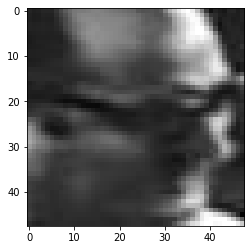

CPU times: user 28.3 ms, sys: 0 ns, total: 28.3 ms
Wall time: 26.6 ms
MIDDLE


In [36]:
from tqdm import tqdm 

dic = {0 : 'MIDDLE' , 1 : 'OLD' , 2 : 'YOUNG'}

image = np.random.choice(Images)

img = LoadImage(image)
img = img.reshape(1 , 75 , 75 , 3)
%time pred = loaded_model.predict(img)
pred = np.argmax(pred)
print(dic[pred])